Main objective for this week is to implement code to manipulate the spectra to adjust for redshift. Secondary objective is to identify the first handful of absoption lines in the spectra.

The first edit is to make sure to import data from astropy.

In [1]:
import numpy as np
import json, sys, os

import matplotlib.pyplot as plt
from matplotlib import rc, cm

## Also now importing astropy units and constants to use in shfiting
from astropy import units as u
from astropy import constants as const

# Get the path of the current directory
path = os.getcwd()
home = os.path.dirname(path)

# Print the repository home directory
print("Repository home directory:",home)

# Add the src folder to the system path
sys.path.append(home+'/src')

# Import the python functions stored in the src folder
from calculations import Calc, Model, Stats

# We shorten the functions name to make it easier to call the required a functions
## 3 functions from P.Strom written code
c   = Calc()
m   = Model()
s   = Stats()

# Importing parameters from a json file.
# You can use this file to edit parameters later.

## Editing the paramenters in a file proves easier than writing it into the code 
with open(home+'/params.json') as param_file:    
   param = json.load(param_file)

# We read in the data directories we are using. To see what directories this is open params.json.
datadirs = param["datadirs"]

# Choose what part of the spectrum you wan to look at
# B is the blue end, whilst A is the red end)
part     = param["BetaPictoris"]["part"]

Repository home directory: C:\Users\Oliver\Documents\urss


In [2]:
# Load the data into the multidimentional array D
if param["filenames"]["split_files"] == "yes":
    D = c.LoadData(home+'/data/D_'+part+'_split.npz')
else:
    D = c.LoadData(home+'/data/D_'+part+'.npz')

As I had been exploring towards the end of week 2, to adjust for redshift we will use the doppler shift equation as seen below. At the time my methods were clear but after a few days away from the project reviewing the code shows that it was over-complicated and a little messy.With guidance from P.Strom, the following is a much more consisice version

$$\frac{\Delta \lambda}{\lambda_0} = \frac{v}{c}$$

Rearranged as:
$$ \Delta \lambda = \frac{v}{c}\lambda_0 $$

$\Delta \lambda$ is the wavelength shift  
$\lambda_0$ is the wavelength of the stationary source  
$v$ is the speed of the source (radial velocity)     
$c$ is the speed of light

In [3]:
#Using SiII as example to see if the equation works before adpating it to use on the whole spectrum.
#Defining beta pic radial velocity 
beta_pic_speed = 20.5*(u.km/u.s)

#Stating w_SiII as its wavelength in angstroms (using astropy)
##I also tried varifying this wavelength on NIST but it only had it as 1309.27  
w_SiII = 1309.2758*u.angstrom

#The shift calculation as seen from the rearranged formula above 
shift = (beta_pic_speed / const.c)*w_SiII

In [4]:
#Just showing the difference between just printing and using astropy to sort out the units of the shift.
print(shift)
shift.to(u.angstrom)

8.952911650632651e-05 Angstrom km / m


<Quantity 0.08952912 Angstrom>

This shows that the shift for this point in our spectrum is ~0.09 Angstrom. However this will vary slightly accross the whole spectrum as the wavelength varies. So now I will copy the code from Week 2 which gave me the combined spectrum and apply the shift to the that spectrum with the normalised weighted average. 

In [5]:
## From Week 2
## First setting the wavelength limits
## Removed printing throughout

#Finding the wavelength range to then find the number of data points per angstrom
w = D[0][0][0][5000:15000]

# Wavelength range
w_range = (w[9999]-w[0])

# Data points per wavelength 
p_per_w = 10000/w_range

# Finding the data point range needed to get 1340-1390
LHS_gap_w = (1340-w[0]) #LHS difference in angstroms 
LHS_gap_d = LHS_gap_w*p_per_w # LHS difference in points
LHS_gap_d = round(LHS_gap_d)

RHS_gap_w = (w[9999]-1390) #RHS difference in angstroms 
RHS_gap_d = RHS_gap_w*p_per_w # RHS difference in points
RHS_gap_d = round(RHS_gap_d)

w_LHS = 5000 + LHS_gap_d
w_RHS = 15000 - RHS_gap_d

w = D[0][0][0][w_LHS:w_RHS] #Redefining w with its new boundaries

In [6]:
## From Week 2 
## Code for Normalising the Points in new reigon
## Removed the printing at the end

# Creating empty lists for our Flux, Error in Flux, corrected flux values 
d0 = [] # Flux
e0 = [] # Error
d0_n = [] # Corrected flux values (Normalised)

# Extracting the Flux and Flux Error data for each observation and putting them into d0 and e0
for i in range(len(D)): # For each visit (repeat for all 13 data collections)
    for j in range(len(D[i])): # Within each visit (cycle over number of orbits)
        if j == 0: # If orbit == 0 (for the first orbit only - as we are interested in unshifted data)
            d0.append(D[i][j][1][w_LHS:w_RHS]) # Add to d0 the y values (Flux)
            e0.append(D[i][j][2][w_LHS:w_RHS]) # Add to e0 the y error values (Error in Flux)

            
# Converting lists into numpy arrays (allowing for easier manipulation later on with averaging functions)
d0 = np.array(d0)
e0 = np.array(e0)
w = D[0][0][0][w_LHS:w_RHS] # Defining w as the width of the spectra (more simple for plotting and can easily apply boundaries) 



# Normalisation - correcting for different exposure times (exposure time effects Flux, we move all into same frame)

for i in range(len(d0)): # For loop - repeating for each data set 
    factor = np.median(d0[i])/np.median(d0[0]) # Calculating the normalisation factor (how much each spectrum is off from 1st)
    d0_n.append(d0[i]/factor) # (Spectrum flux values/spectrum normalisation factor), making d0_n corrected flux values 


# Converting list into array - only after using .append 
d0_n = np.array(d0_n)

## Simple average
#d0_ave = np.average(d0,axis=0)

## Weighted average
#d0_w_ave = np.average(d0 , axis = 0 , weights = 1/e0**2)

## Normalised weighted average 
d0_n_w_ave = np.average(d0_n , axis = 0 , weights = 1/e0**2)

print(d0_n_w_ave)

[2.04805303e-13 2.13104164e-13 2.13082365e-13 ... 3.02090392e-13
 3.05880936e-13 3.09022306e-13]


Now we have the normalised weighted average - we apply the shift to the whole spectrum. (Plotted without shift before for comparison - deleted in hindsight as the shift is minisucle on this scale).

In [7]:
# Shifting the whole spectrum by taking the wavelength array created earlier (w) and substituting it into the rearranged
# doppler shift equation stated earlier

w_shifted = w-(beta_pic_speed / const.c)*w

# Quick visual check to see the shift, shows either end of the array.
print(w)
print(w_shifted)

[1340.00089879 1340.01086546 1340.02083213 ... 1389.97377682 1389.98374349
 1389.99371016]
[1339.90926867 1339.91923466 1339.92920065 ... 1389.87872952 1389.88869551
 1389.8986615 ]


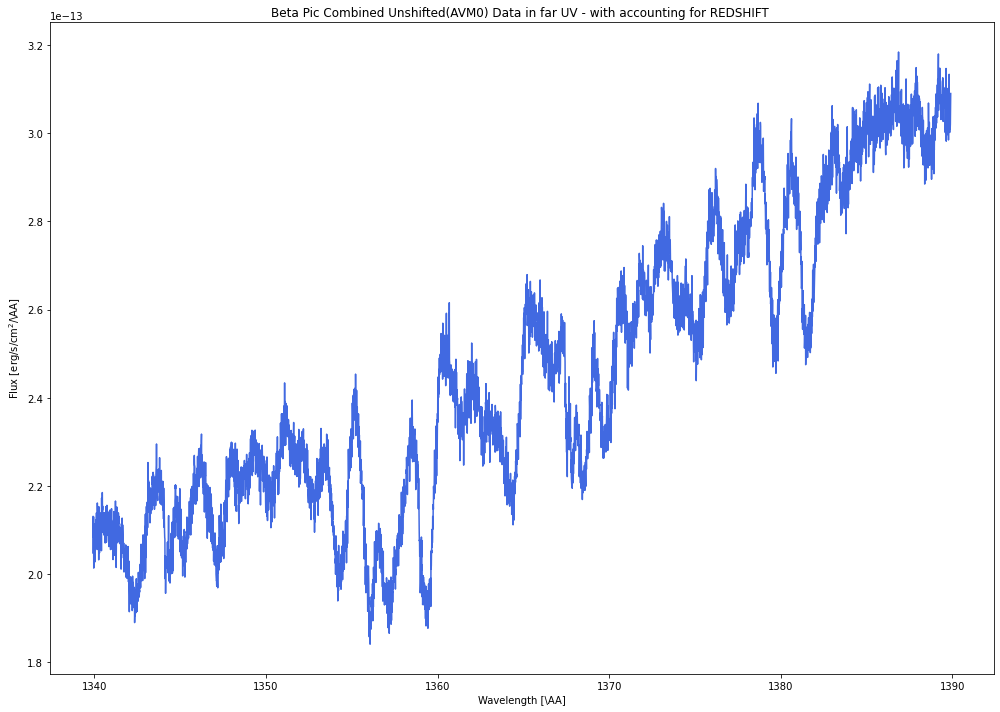

In [8]:
# Plotting the spectrum with the shifted wavelengths 

fig = plt.figure(figsize=(14.0,10.0))

# Normalised weighted average by shifted wavelengths
plt.plot(w_shifted, d0_n_w_ave , color = "royalblue")
plt.title("Beta Pic Combined Unshifted(AVM0) Data in far UV - with accounting for REDSHIFT ")
plt.xlabel(r'Wavelength [\AA]')
plt.ylabel(r'Flux [erg/s/cm$^2$/\AA]')
fig.tight_layout()


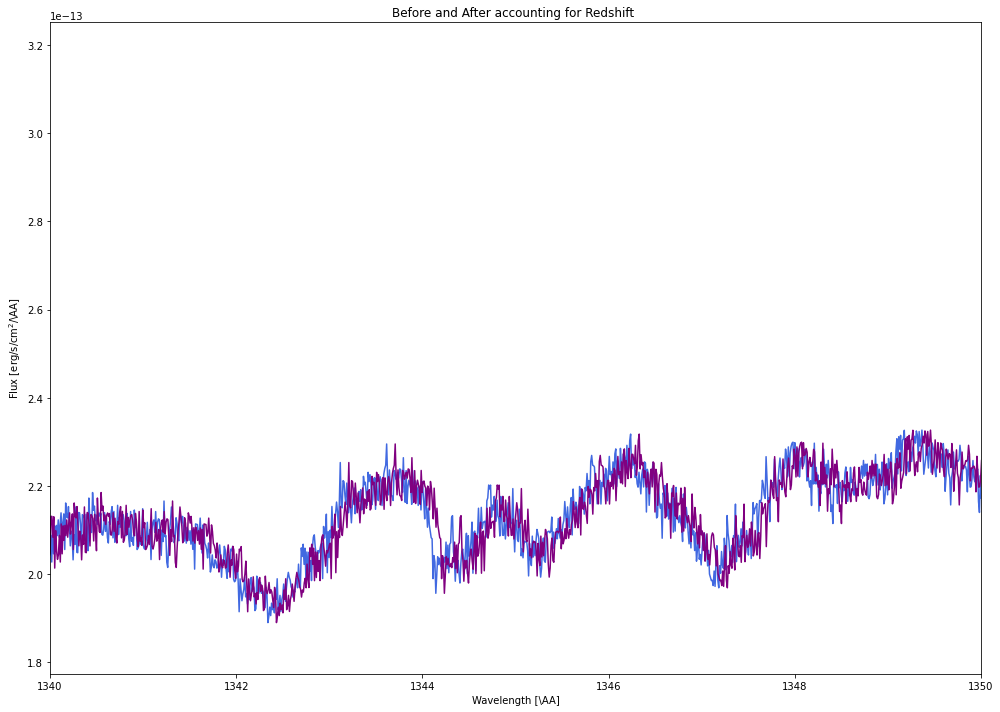

In [9]:
#Replotting the spectrum with the shifted wavelengths and the unshifted wavelengths 

fig = plt.figure(figsize=(14.0,10.0))

# Normalised weighted average by shifted wavelengths
plt.plot(w_shifted, d0_n_w_ave , color = "royalblue")
plt.plot(w, d0_n_w_ave , color = "purple")
plt.title("Before and After accounting for Redshift ")
plt.xlabel(r'Wavelength [\AA]')
plt.ylabel(r'Flux [erg/s/cm$^2$/\AA]')
plt.xlim(1340, 1350)
fig.tight_layout()

Now as the wavelengths are corrected I using the NIST ASD database and Atomic Data will be identifying some of the elements present. 

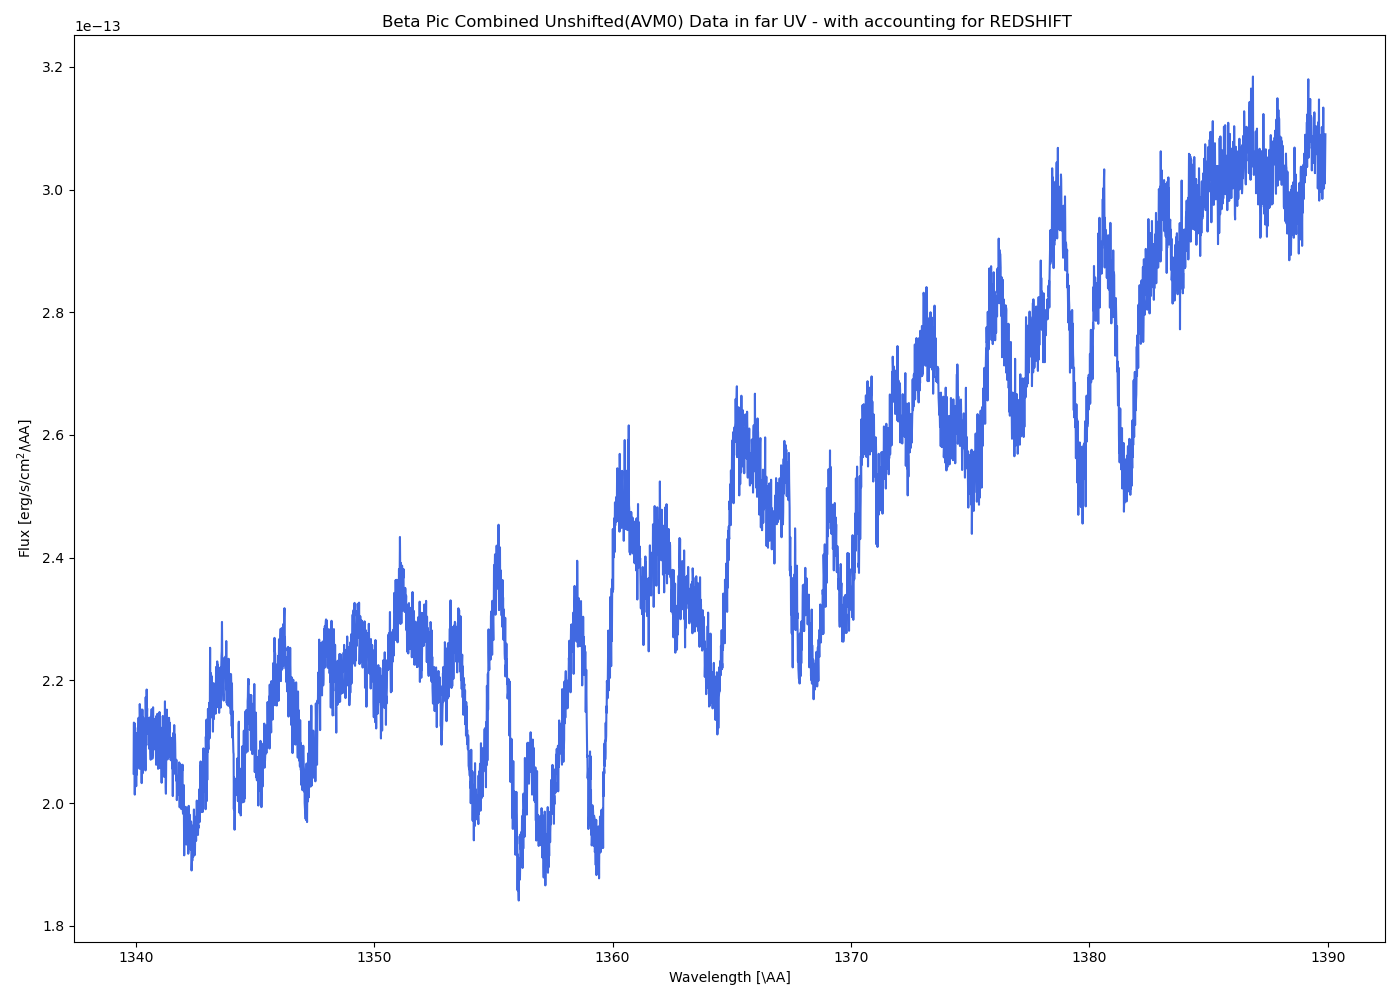

In [10]:
# Using the matplotlib widget to zoom into specific lines and record their wavelengths in the new spectrum.
%matplotlib widget

fig = plt.figure(figsize=(14.0,10.0))

# Normalised weighted average by shifted wavelengths
plt.plot(w_shifted, d0_n_w_ave , color = "royalblue")
plt.title("Beta Pic Combined Unshifted(AVM0) Data in far UV - with accounting for REDSHIFT ")
plt.xlabel(r'Wavelength [\AA]')
plt.ylabel(r'Flux [erg/s/cm$^2$/\AA]')
fig.tight_layout()


Making a list of first handful of wavelengths - not all of these will be actual lines/accurate as I am identifying them by eye and using the crosshairs on the matplotlib widget to get the wavelengths . - A conversation point, surely there must be  a way to code this by downloading the data base for 1340-1390 and code some sort of absorption line detection thing by having a % threshhold for soemthing like a line of bestfit and if outside the threshhold it scans the database for any corresponding matches?

lines = [1342.3410 ,1344.1449, 1344.3547 , 1344.4040 , 1345.1417 , 1345.2714 , 1347.1451 , 1347.1846 , 1348.4101 , 1350.2838,
         1352.6260 , 1352.8251 , *1354.1809 , *1356.0641 , *1357.1804 , 1359.3223 , *1359.3820 , *1359.4332 , 1361.2967, 
         1361.5158 , 1362.6314 , 1362.6819 , 1362.7017  , *1364.3964]

* = very strong absoption line

Possible matches using from NIST:
( ___ = no match , XX XX = close match , XX XX (?) = weaker match)
1342.3410 = 
1344.1449 = Mn II 
1344.3547 = Mn II 
1344.4040 = W III (?)
1345.1417 = W III(?)
1345.2714 = Ir IV (?)
1347.1451 = 
1347.1846 = 
1348.4101 = W III
1350.2838 = Re III (?)
1352.6260 = Si II (?) 
1352.8251 = Mn II (?) / AU I (?)
*1354.1809 = Sr IV (Wasnt this one of the ones that had been noted before? -  Highly reactive so interesting)
*1356.0641 = Fe III
*1357.1804 = Co II 
1359.3223 = Fe II 
*1359.3820 = Y V (?)
1361.2967 = S I (?)
1361.5158 = Y V (?)
1362.6314 = W III
1362.6819 = PT II (?)
1362.7017 = Bi III (?)
*1364.3964 = W III (?)

Interesting elements to note here, it is encouraging that there are lots of repeats, especially that of points where the difference in wavelength is very small - as this shows the hyperfine splitting. Mainly transition metals which I would say makes sense as not too reactive, got hints of some quite heavy transition metals towards the end with Bismuth and Platinum. Interesting to note a strong clear absorption line for Strontium (which may have been detected before?) but I am underthe impression it is a quite highly reactive alkali metal. 
